In [1]:
import pandas as pd
import numpy as np
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select

# Explicit Waits 사용을 위한 라이브러리
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from selenium.common.exceptions import NoSuchElementException

# 크롬 드라이버 자동 업데이트
from webdriver_manager.chrome import ChromeDriverManager

import time

In [2]:
# 브라우저 꺼짐 방지
chrome_options = Options()
chrome_options.add_experimental_option("detach", True)

In [3]:
# 불필요한 에러 메시지 없애기
chrome_options.add_experimental_option("excludeSwitches", ["enable-logging"])

In [4]:
service = Service(executable_path=ChromeDriverManager().install())
service

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [C:\Users\Administrator\.wdm\drivers\chromedriver\win32\102.0.5005.61\chromedriver.exe] found in cache


In [5]:
driver = webdriver.Chrome(service=service, options=chrome_options)
driver

<selenium.webdriver.chrome.webdriver.WebDriver (session="56b9e99965feed7a521004bbbec104ed")>

In [6]:
# 웹페이지 해당 주소 이동
driver.implicitly_wait(5)  # 웹페이지가 로딩 될때까지 5초 기다림
driver.maximize_window()  # 화면 최대화

# 21대 국회의원 선거 스크래핑

In [7]:
# 시작. 페이지로 출발
driver.get('http://info.nec.go.kr/')

In [8]:
driver.switch_to.default_content()

In [9]:
driver.switch_to.frame('main')

In [10]:
driver.find_element(By.XPATH, '//*[@id="header"]/ul/li[2]/a/span[text() = "역대선거"]').click() # 역대선거
driver.implicitly_wait(5)

In [11]:
driver.find_element(By.XPATH, '//*[@id="presubmu"]/li[4]/a/span[text() = "투·개표"]').click() # 투개표
driver.implicitly_wait(5)

### 개표현황(읍면동별) 데이터프레임 처리 및 스크래핑한 자료 검증

- 콤보박스에서 조회할 목록(시도명, 구시군명)을 가져오고 스크랩한 데이터의 조회결과 내용과 같은지 비교한다.
- 매칭이 되지 않을 경우 프로그램 중단

In [12]:
# 개표현황(읍면동별)

def get_data(city, town):
    html = driver.page_source

    df1 = pd.read_html(html, header=0)
    df2 = df1[0].copy()
    
    result = driver.find_element(By.XPATH, '//*[@id="contentarea"]/div[2]/div[2]/div[1]/p[@class="selectCondition"]').text
    result = result.strip().replace('[', '').replace(']', '').replace('\n', ' ')
    
    if city in result:
        if town in result:
            df2['조회결과'] = result
        else:
            print(f'에러 - 조회결과에 문제가 있습니다.\n요청 : {city} {town}\n결과 : {result}')
            print('프로그램을 중단합니다.')
            sys.exit()
    else:
        print(f'에러 - 조회결과에 문제가 있습니다\n요청 : {city}\n결과 : {result}')
        print('프로그램을 중단합니다.')
        sys.exit()

    return df2

In [13]:
# 개표현황(읍면동별)

driver.find_element(By.XPATH, '//*[@id="header"]/div[4]/ul/li[6]/a[text() = "개표현황(읍면동별)"]').click()
driver.implicitly_wait(5)

driver.find_element(By.XPATH, '//*[@id="electionType2"]').click() # 국회의원 선거
time.sleep(1)

driver.find_element(By.XPATH, '//*[@id="electionName"]').send_keys('제21대')
time.sleep(1)

driver.find_element(By.XPATH, '//*[@id="electionCode"]').send_keys('국회의원선거')
time.sleep(1)

df_21 = pd.DataFrame()

combo_box_3 = driver.find_element(By.XPATH, '//*[@id="cityCode"]')
cityCodes = [option.text for option in combo_box_3.find_elements(By.TAG_NAME, "option")]
cityCodes.pop(0)

for cityCode in cityCodes:
    driver.find_element(By.XPATH, '//*[@id="cityCode"]').send_keys(cityCode)
    time.sleep(1)
    
    combo_box_4 = driver.find_element(By.XPATH, '//*[@id="townCode"]')
    townCodes = [option.text for option in combo_box_4.find_elements(By.TAG_NAME, "option")]
    townCodes.pop(0)    
    
    for townCode in townCodes:
        driver.find_element(By.XPATH, '//*[@id="townCode"]').send_keys(townCode)
        time.sleep(1)
        
        driver.find_element(By.XPATH, '//*[@id="searchBtn"]').click()
        driver.implicitly_wait(5)
        
        df_21 = pd.concat([df_21, get_data(cityCode, townCode)], ignore_index=True)
        time.sleep(1)
        
df_21.tail()

,선거구명,읍면동명,구분,선거인수,투표수,후보자별 득표수,후보자별 득표수.1,후보자별 득표수.2,후보자별 득표수.3,후보자별 득표수.4,후보자별 득표수.5,후보자별 득표수.6,후보자별 득표수.7,후보자별 득표수.8,후보자별 득표수.9,후보자별 득표수.10,후보자별 득표수.11,무효투표수,기권수,조회결과
12823,NaN,중문동,선거일투표,6478,3581,1641,1820,56,3517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64,2897,제21대 국회의원선거 국회의원선거 제주특별자치도 서귀포시
12824,NaN,예래동,계,3197,2155,917,1159,31,2107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48,1042,제21대 국회의원선거 국회의원선거 제주특별자치도 서귀포시
12825,NaN,예래동,관내사전투표,765,764,346,393,6,745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,1,제21대 국회의원선거 국회의원선거 제주특별자치도 서귀포시
12826,NaN,예래동,선거일투표,2432,1391,571,766,25,1362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,1041,제21대 국회의원선거 국회의원선거 제주특별자치도 서귀포시
12827,NaN,잘못 투입·구분된 투표지,NaN,0,8,7,1,0,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,-8,제21대 국회의원선거 국회의원선거 제주특별자치도 서귀포시


## 21대 총선 데이터프레임 원본 (df_21)

In [14]:
# 선거구분, 시도명, 구시군명 열 분리

df_21['선거구분'] = df_21['조회결과'].str.split().str[2]
df_21['시도명'] = df_21['조회결과'].str.split().str[3]
df_21['구시군명'] = df_21['조회결과'].str.split().str[4]
df_21 = df_21[['선거구분', '시도명', '구시군명', '선거구명', '읍면동명', '구분', '선거인수', '투표수', '후보자별 득표수', '후보자별 득표수.1',
       '후보자별 득표수.2', '후보자별 득표수.3', '후보자별 득표수.4', '후보자별 득표수.5', '후보자별 득표수.6',
       '후보자별 득표수.7', '후보자별 득표수.8', '후보자별 득표수.9', '후보자별 득표수.10', '후보자별 득표수.11',
       '무효투표수', '기권수', '조회결과']]
df_21.shape

(12828, 23)

In [15]:
df_21 = df_21[df_21['후보자별 득표수'] != '후보자별 득표수'].copy() # 필요없는 값 삭제
df_21.shape

(12758, 23)

In [16]:
df_21['선거구명'] = df_21['선거구명'].shift(periods=-1) # 한칸 비틀어 올리고
df_21['선거구명'] = df_21['선거구명'].replace('선거구명', np.nan) # 필요없는 값은 NaN으로 변경
df_21['선거구명'] = df_21['선거구명'].fillna(method='ffill') # 결측값 연속 채우기
df_21.shape

(12758, 23)

### 21대 총선 후보자 목록 분리 (df_21_candi)

In [17]:
df_21_candi = df_21[df_21['후보자별 득표수'].str.contains('더불어민주당')]
df_21_candi.shape

(329, 23)

In [18]:
df_21_candi.tail()

,선거구분,시도명,구시군명,선거구명,읍면동명,구분,선거인수,투표수,후보자별 득표수,후보자별 득표수.1,...,후보자별 득표수.5,후보자별 득표수.6,후보자별 득표수.7,후보자별 득표수.8,후보자별 득표수.9,후보자별 득표수.10,후보자별 득표수.11,무효투표수,기권수,조회결과
12576,국회의원선거,경상남도,거창군,산청군함양군거창군합천군,읍면동명,구분,선거인수,투표수,더불어민주당서필상,미래통합당강석진,...,국가혁명배당금당김태영,무소속김태호,계,NaN,NaN,NaN,NaN,무효투표수,기권수,제21대 국회의원선거 국회의원선거 경상남도 거창군
12619,국회의원선거,경상남도,합천군,산청군함양군거창군합천군,읍면동명,구분,선거인수,투표수,더불어민주당서필상,미래통합당강석진,...,국가혁명배당금당김태영,무소속김태호,계,NaN,NaN,NaN,NaN,무효투표수,기권수,제21대 국회의원선거 국회의원선거 경상남도 합천군
12678,국회의원선거,제주특별자치도,제주시,제주시갑,NaN,NaN,NaN,NaN,더불어민주당송재호,미래통합당장성철,...,무소속박희수,무소속임효준,계,NaN,NaN,NaN,NaN,NaN,NaN,제21대 국회의원선거 국회의원선거 제주특별자치도 제주시
12727,국회의원선거,제주특별자치도,제주시,제주시을,NaN,NaN,NaN,NaN,더불어민주당오영훈,미래통합당부상일,...,NaN,NaN,계,NaN,NaN,NaN,NaN,NaN,NaN,제21대 국회의원선거 국회의원선거 제주특별자치도 제주시
12770,국회의원선거,제주특별자치도,서귀포시,서귀포시,읍면동명,구분,선거인수,투표수,더불어민주당위성곤,미래통합당강경필,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,무효투표수,기권수,제21대 국회의원선거 국회의원선거 제주특별자치도 서귀포시


In [19]:
df_21_candi = df_21_candi[['선거구분', '시도명', '구시군명', '선거구명', '후보자별 득표수',
                           '후보자별 득표수.1', '후보자별 득표수.2', '후보자별 득표수.3', '후보자별 득표수.4', '후보자별 득표수.5',
                           '후보자별 득표수.6', '후보자별 득표수.7', '후보자별 득표수.8', '후보자별 득표수.9', '후보자별 득표수.10',
                           '후보자별 득표수.11', '조회결과']]

In [20]:
df_21_candi.columns = ['선거구분', '시도명', '구시군명', '선거구명',
                       '후보자1', '후보자2', '후보자3', '후보자4', '후보자5', '후보자6', '후보자7', '후보자8',
                       '후보자9', '후보자10', '후보자11', '후보자12', '조회결과']

In [21]:
df_21_candi.loc[:,'후보자1' : '후보자12'] = df_21_candi.loc[:,'후보자1' : '후보자12'].replace('계', np.nan) # 쓰레기 값 삭제
df_21_candi.head()

,선거구분,시도명,구시군명,선거구명,후보자1,후보자2,후보자3,후보자4,후보자5,후보자6,후보자7,후보자8,후보자9,후보자10,후보자11,후보자12,조회결과
0,국회의원선거,서울특별시,종로구,종로구,더불어민주당이낙연,미래통합당황교안,우리공화당한민호,민중당오인환,가자!평화인권당이정희,공화당신동욱,국가혁명배당금당박준영,국민새정당백병찬,민중민주당박소현,한나라당김형석,무소속김용덕,NaN,제21대 국회의원선거 국회의원선거 서울특별시 종로구
58,국회의원선거,서울특별시,중구,중구성동구을,더불어민주당박성준,미래통합당지상욱,국가혁명배당금당이주양,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,제21대 국회의원선거 국회의원선거 서울특별시 중구
122,국회의원선거,서울특별시,용산구,용산구,더불어민주당강태웅,미래통합당권영세,민생당권혁문,정의당정연욱,민중당김은희,국가혁명배당금당김희전,NaN,NaN,NaN,NaN,NaN,NaN,제21대 국회의원선거 국회의원선거 서울특별시 용산구
177,국회의원선거,서울특별시,성동구,중구성동구갑,더불어민주당홍익표,미래통합당진수희,정의당정혜연,국가혁명배당금당이정섭,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,제21대 국회의원선거 국회의원선거 서울특별시 성동구
224,국회의원선거,서울특별시,광진구,광진구갑,더불어민주당전혜숙,미래통합당김병민,민생당임동순,정의당오봉석,국가혁명배당금당이승욱,NaN,NaN,NaN,NaN,NaN,NaN,NaN,제21대 국회의원선거 국회의원선거 서울특별시 광진구


#### 당명 공백으로 분리

- replace는 기본적으로 좌측부터 처리
- 이번 선거에서 당명은 '국가혁명배당금당'을 제외하면 '당'으로 끝나고 1자만 들어간다.
- '국가혁명배당금당'은 2번 처리
- '친박연대' 같은 당이 나온다면 추가로 처리해야 한다.
- replace 는 1회만 처리한다. ('당' 이 이름에 들어가 있는 경우도 있을 수 있음)

In [22]:
for i in range(4, 16):
    df_21_candi.iloc[:, i] = df_21_candi.iloc[:, i].str.replace('당', '당 ', 1)
    df_21_candi.iloc[:, i] = df_21_candi.iloc[:, i].str.replace('무소속', '무소속 ', 1)

for i in range(4, 16):
    df_21_candi.iloc[:, i] = df_21_candi.iloc[:, i].str.replace('배당 금당', '배당금당 ', 1)

df_21_candi = df_21_candi.reset_index(drop=True)
df_21_candi.head()

,선거구분,시도명,구시군명,선거구명,후보자1,후보자2,후보자3,후보자4,후보자5,후보자6,후보자7,후보자8,후보자9,후보자10,후보자11,후보자12,조회결과
0,국회의원선거,서울특별시,종로구,종로구,더불어민주당 이낙연,미래통합당 황교안,우리공화당 한민호,민중당 오인환,가자!평화인권당 이정희,공화당 신동욱,국가혁명배당금당 박준영,국민새정당 백병찬,민중민주당 박소현,한나라당 김형석,무소속 김용덕,NaN,제21대 국회의원선거 국회의원선거 서울특별시 종로구
1,국회의원선거,서울특별시,중구,중구성동구을,더불어민주당 박성준,미래통합당 지상욱,국가혁명배당금당 이주양,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,제21대 국회의원선거 국회의원선거 서울특별시 중구
2,국회의원선거,서울특별시,용산구,용산구,더불어민주당 강태웅,미래통합당 권영세,민생당 권혁문,정의당 정연욱,민중당 김은희,국가혁명배당금당 김희전,NaN,NaN,NaN,NaN,NaN,NaN,제21대 국회의원선거 국회의원선거 서울특별시 용산구
3,국회의원선거,서울특별시,성동구,중구성동구갑,더불어민주당 홍익표,미래통합당 진수희,정의당 정혜연,국가혁명배당금당 이정섭,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,제21대 국회의원선거 국회의원선거 서울특별시 성동구
4,국회의원선거,서울특별시,광진구,광진구갑,더불어민주당 전혜숙,미래통합당 김병민,민생당 임동순,정의당 오봉석,국가혁명배당금당 이승욱,NaN,NaN,NaN,NaN,NaN,NaN,NaN,제21대 국회의원선거 국회의원선거 서울특별시 광진구


#### 21대 총선 양당 데이터만 집계 (df_21_candi_big2)

In [23]:
df_21_candi_big2 = df_21_candi.iloc[:, :6]
df_21_candi_big2

,선거구분,시도명,구시군명,선거구명,후보자1,후보자2
0,국회의원선거,서울특별시,종로구,종로구,더불어민주당 이낙연,미래통합당 황교안
1,국회의원선거,서울특별시,중구,중구성동구을,더불어민주당 박성준,미래통합당 지상욱
2,국회의원선거,서울특별시,용산구,용산구,더불어민주당 강태웅,미래통합당 권영세
3,국회의원선거,서울특별시,성동구,중구성동구갑,더불어민주당 홍익표,미래통합당 진수희
4,국회의원선거,서울특별시,광진구,광진구갑,더불어민주당 전혜숙,미래통합당 김병민
...,...,...,...,...,...,...
324,국회의원선거,경상남도,거창군,산청군함양군거창군합천군,더불어민주당 서필상,미래통합당 강석진
325,국회의원선거,경상남도,합천군,산청군함양군거창군합천군,더불어민주당 서필상,미래통합당 강석진
326,국회의원선거,제주특별자치도,제주시,제주시갑,더불어민주당 송재호,미래통합당 장성철
327,국회의원선거,제주특별자치도,제주시,제주시을,더불어민주당 오영훈,미래통합당 부상일


### 21대 총선 득표데이터 분리 (df_21_vote)

In [24]:
df_21_vote = df_21[~df_21['후보자별 득표수'].str.contains('더불어민주당')]
df_21_vote.shape

(12429, 23)

In [25]:
df_21_vote.head()

,선거구분,시도명,구시군명,선거구명,읍면동명,구분,선거인수,투표수,후보자별 득표수,후보자별 득표수.1,...,후보자별 득표수.5,후보자별 득표수.6,후보자별 득표수.7,후보자별 득표수.8,후보자별 득표수.9,후보자별 득표수.10,후보자별 득표수.11,무효투표수,기권수,조회결과
1,국회의원선거,서울특별시,종로구,종로구,합계,NaN,134516,95239,54902,37594,...,57,194,65,63,71,260,94038,1201,39277,제21대 국회의원선거 국회의원선거 서울특별시 종로구
2,국회의원선거,서울특별시,종로구,종로구,거소·선상투표,NaN,251,237,135,81,...,0,5,0,0,0,3,226,11,14,제21대 국회의원선거 국회의원선거 서울특별시 종로구
3,국회의원선거,서울특별시,종로구,종로구,관외사전투표,NaN,10007,9994,6472,3169,...,7,25,7,10,11,42,9823,171,13,제21대 국회의원선거 국회의원선거 서울특별시 종로구
4,국회의원선거,서울특별시,종로구,종로구,국외부재자투표,NaN,1177,321,232,80,...,1,0,0,0,1,2,317,4,856,제21대 국회의원선거 국회의원선거 서울특별시 종로구
5,국회의원선거,서울특별시,종로구,종로구,국외부재자투표(공관),NaN,0,12,11,1,...,0,0,0,0,0,0,12,0,-12,제21대 국회의원선거 국회의원선거 서울특별시 종로구


In [26]:
df_21_vote.dtypes

선거구분           object
시도명            object
구시군명           object
선거구명           object
읍면동명           object
구분             object
선거인수           object
투표수            object
후보자별 득표수       object
후보자별 득표수.1     object
후보자별 득표수.2     object
후보자별 득표수.3     object
후보자별 득표수.4     object
후보자별 득표수.5     object
후보자별 득표수.6     object
후보자별 득표수.7     object
후보자별 득표수.8     object
후보자별 득표수.9     object
후보자별 득표수.10    object
후보자별 득표수.11    object
무효투표수          object
기권수            object
조회결과           object
dtype: object

In [27]:
df_21_vote.columns = ['선거구분', '시도명', '구시군명', '선거구명', '읍면동명', '구분', '선거인수', '투표수',
                       '득표수1', '득표수2', '득표수3', '득표수4', '득표수5', '득표수6', '득표수7', '득표수8',
                       '득표수9', '득표수10', '득표수11', '득표수12', '무효투표수', '기권수', '조회결과']

In [28]:
df_21_vote.isnull().sum()

선거구분         0
시도명          0
구시군명         0
선거구명         0
읍면동명         0
구분        1974
선거인수         0
투표수          0
득표수1         0
득표수2         0
득표수3         0
득표수4       222
득표수5      2472
득표수6      6963
득표수7      9738
득표수8     11436
득표수9     12204
득표수10    12372
득표수11    12372
득표수12    12372
무효투표수        0
기권수          0
조회결과         0
dtype: int64

#### 21대 총선 선거구명 집계 (df_21_vote_sum)

In [29]:
df_21_vote_sum = df_21_vote[df_21_vote['읍면동명'] == '합계'].copy()
df_21_vote_sum

,선거구분,시도명,구시군명,선거구명,읍면동명,구분,선거인수,투표수,득표수1,득표수2,...,득표수6,득표수7,득표수8,득표수9,득표수10,득표수11,득표수12,무효투표수,기권수,조회결과
1,국회의원선거,서울특별시,종로구,종로구,합계,NaN,134516,95239,54902,37594,...,57,194,65,63,71,260,94038,1201,39277,제21대 국회의원선거 국회의원선거 서울특별시 종로구
59,국회의원선거,서울특별시,중구,중구성동구을,합계,NaN,183779,124700,64071,58300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1392,59079,제21대 국회의원선거 국회의원선거 서울특별시 중구
123,국회의원선거,서울특별시,용산구,용산구,합계,NaN,203233,135043,63001,63891,...,541,133643,NaN,NaN,NaN,NaN,NaN,1400,68190,제21대 국회의원선거 국회의원선거 서울특별시 용산구
178,국회의원선거,서울특별시,성동구,중구성동구갑,합계,NaN,192161,131200,70387,53107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1455,60961,제21대 국회의원선거 국회의원선거 서울특별시 성동구
225,국회의원선거,서울특별시,광진구,광진구갑,합계,NaN,156559,106506,56608,42822,...,105454,NaN,NaN,NaN,NaN,NaN,NaN,1052,50053,제21대 국회의원선거 국회의원선거 서울특별시 광진구
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12577,국회의원선거,경상남도,거창군,산청군함양군거창군합천군,합계,NaN,53599,38976,6373,13147,...,390,17755,38307,NaN,NaN,NaN,NaN,669,14623,제21대 국회의원선거 국회의원선거 경상남도 거창군
12620,국회의원선거,경상남도,합천군,산청군함양군거창군합천군,합계,NaN,41197,29891,4063,12660,...,337,11597,29198,NaN,NaN,NaN,NaN,693,11306,제21대 국회의원선거 국회의원선거 경상남도 합천군
12679,국회의원선거,제주특별자치도,제주시,제주시갑,합계,NaN,208660,128031,61626,46909,...,6901,547,126540,NaN,NaN,NaN,NaN,1491,80629,제21대 국회의원선거 국회의원선거 제주특별자치도 제주시
12728,국회의원선거,제주특별자치도,제주시,제주시을,합계,NaN,191862,122883,67206,49862,...,0,0,121412,NaN,NaN,NaN,NaN,1471,68979,제21대 국회의원선거 국회의원선거 제주특별자치도 제주시


In [30]:
# NaN 옆의 값이 득표 총 합계값인데 행마다 출마인원이 달라 위치가 다름.
# 득표수12 컬럼까지 쭉 채워서 득표수12 컬럼을 득표총합으로 활용한다.
# 득표수1 / 득표수12 = 득표율1 로 처리
df_21_vote_sum = df_21_vote_sum.fillna(method = 'ffill', axis=1)

In [31]:
df_21_vote_sum = df_21_vote_sum.astype({
    '선거인수' : 'int',
    '투표수' : 'int',
    '득표수1' : 'int',
    '득표수2' : 'int',
    '득표수3' : 'int',
    '득표수4' : 'int',
    '득표수5' : 'int',
    '득표수6' : 'int',
    '득표수7' : 'int',
    '득표수8' : 'int',
    '득표수9' : 'int',
    '득표수10' : 'int',
    '득표수11' : 'int',
    '득표수12' : 'int',
    '무효투표수' : 'int',
    '기권수' : 'int'
})
df_21_vote_sum.dtypes

선거구분     object
시도명      object
구시군명     object
선거구명     object
읍면동명     object
구분       object
선거인수      int32
투표수       int32
득표수1      int32
득표수2      int32
득표수3      int32
득표수4      int32
득표수5      int32
득표수6      int32
득표수7      int32
득표수8      int32
득표수9      int32
득표수10     int32
득표수11     int32
득표수12     int32
무효투표수     int32
기권수       int32
조회결과     object
dtype: object

In [32]:
# 득표율 구하기
df_21_vote_sum['득표율1'] = df_21_vote_sum['득표수1'] / df_21_vote_sum['득표수12']
df_21_vote_sum['득표율2'] = df_21_vote_sum['득표수2'] / df_21_vote_sum['득표수12']
df_21_vote_sum

,선거구분,시도명,구시군명,선거구명,읍면동명,구분,선거인수,투표수,득표수1,득표수2,...,득표수8,득표수9,득표수10,득표수11,득표수12,무효투표수,기권수,조회결과,득표율1,득표율2
1,국회의원선거,서울특별시,종로구,종로구,합계,합계,134516,95239,54902,37594,...,65,63,71,260,94038,1201,39277,제21대 국회의원선거 국회의원선거 서울특별시 종로구,0.583828,0.399775
59,국회의원선거,서울특별시,중구,중구성동구을,합계,합계,183779,124700,64071,58300,...,123308,123308,123308,123308,123308,1392,59079,제21대 국회의원선거 국회의원선거 서울특별시 중구,0.519601,0.472800
123,국회의원선거,서울특별시,용산구,용산구,합계,합계,203233,135043,63001,63891,...,133643,133643,133643,133643,133643,1400,68190,제21대 국회의원선거 국회의원선거 서울특별시 용산구,0.471413,0.478072
178,국회의원선거,서울특별시,성동구,중구성동구갑,합계,합계,192161,131200,70387,53107,...,129745,129745,129745,129745,129745,1455,60961,제21대 국회의원선거 국회의원선거 서울특별시 성동구,0.542503,0.409318
225,국회의원선거,서울특별시,광진구,광진구갑,합계,합계,156559,106506,56608,42822,...,105454,105454,105454,105454,105454,1052,50053,제21대 국회의원선거 국회의원선거 서울특별시 광진구,0.536803,0.406073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12577,국회의원선거,경상남도,거창군,산청군함양군거창군합천군,합계,합계,53599,38976,6373,13147,...,38307,38307,38307,38307,38307,669,14623,제21대 국회의원선거 국회의원선거 경상남도 거창군,0.166366,0.343201
12620,국회의원선거,경상남도,합천군,산청군함양군거창군합천군,합계,합계,41197,29891,4063,12660,...,29198,29198,29198,29198,29198,693,11306,제21대 국회의원선거 국회의원선거 경상남도 합천군,0.139153,0.433591
12679,국회의원선거,제주특별자치도,제주시,제주시갑,합계,합계,208660,128031,61626,46909,...,126540,126540,126540,126540,126540,1491,80629,제21대 국회의원선거 국회의원선거 제주특별자치도 제주시,0.487008,0.370705
12728,국회의원선거,제주특별자치도,제주시,제주시을,합계,합계,191862,122883,67206,49862,...,121412,121412,121412,121412,121412,1471,68979,제21대 국회의원선거 국회의원선거 제주특별자치도 제주시,0.553537,0.410684


In [33]:
df_21_vote_sum['조회결과'].value_counts()

제21대 국회의원선거 국회의원선거 경기도 부천시         4
제21대 국회의원선거 국회의원선거 서울특별시 송파구       3
제21대 국회의원선거 국회의원선거 서울특별시 강남구       3
제21대 국회의원선거 국회의원선거 대구광역시 달서구       3
제21대 국회의원선거 국회의원선거 경기도 화성시         3
                                  ..
제21대 국회의원선거 국회의원선거 강원도 속초시         1
제21대 국회의원선거 국회의원선거 서울특별시 중구        1
제21대 국회의원선거 국회의원선거 강원도 양양군         1
제21대 국회의원선거 국회의원선거 강원도 인제군         1
제21대 국회의원선거 국회의원선거 제주특별자치도 서귀포시    1
Name: 조회결과, Length: 250, dtype: int64

## 21대 총선 최종데이터 (df_21_total) - 선거구 기준

In [56]:
df_21_total = pd.merge(df_21_candi_big2, df_21_vote_sum.loc[:, ['선거구분', '시도명', '구시군명', '선거구명', '득표율1', '득표율2', '조회결과']], how='left').reset_index(drop=True)
df_21_total

,선거구분,시도명,구시군명,선거구명,후보자1,후보자2,득표율1,득표율2,조회결과
0,국회의원선거,서울특별시,종로구,종로구,더불어민주당 이낙연,미래통합당 황교안,0.583828,0.399775,제21대 국회의원선거 국회의원선거 서울특별시 종로구
1,국회의원선거,서울특별시,중구,중구성동구을,더불어민주당 박성준,미래통합당 지상욱,0.519601,0.472800,제21대 국회의원선거 국회의원선거 서울특별시 중구
2,국회의원선거,서울특별시,용산구,용산구,더불어민주당 강태웅,미래통합당 권영세,0.471413,0.478072,제21대 국회의원선거 국회의원선거 서울특별시 용산구
3,국회의원선거,서울특별시,성동구,중구성동구갑,더불어민주당 홍익표,미래통합당 진수희,0.542503,0.409318,제21대 국회의원선거 국회의원선거 서울특별시 성동구
4,국회의원선거,서울특별시,광진구,광진구갑,더불어민주당 전혜숙,미래통합당 김병민,0.536803,0.406073,제21대 국회의원선거 국회의원선거 서울특별시 광진구
...,...,...,...,...,...,...,...,...,...
324,국회의원선거,경상남도,거창군,산청군함양군거창군합천군,더불어민주당 서필상,미래통합당 강석진,0.166366,0.343201,제21대 국회의원선거 국회의원선거 경상남도 거창군
325,국회의원선거,경상남도,합천군,산청군함양군거창군합천군,더불어민주당 서필상,미래통합당 강석진,0.139153,0.433591,제21대 국회의원선거 국회의원선거 경상남도 합천군
326,국회의원선거,제주특별자치도,제주시,제주시갑,더불어민주당 송재호,미래통합당 장성철,0.487008,0.370705,제21대 국회의원선거 국회의원선거 제주특별자치도 제주시
327,국회의원선거,제주특별자치도,제주시,제주시을,더불어민주당 오영훈,미래통합당 부상일,0.553537,0.410684,제21대 국회의원선거 국회의원선거 제주특별자치도 제주시


# 20대 대통령 선거 스크래핑

In [36]:
driver.find_element(By.XPATH, '//*[@id="header"]/div[1]/ul[1]/li[1]/a/span[text() = "최근선거"]').click() # 연속해서 실행할 땐 xpath가 다르다. 새로 받아와야함.
driver.implicitly_wait(5)

In [37]:
driver.find_element(By.XPATH, '//*[@id="menu"]/ul/li[2]/a[text() = "제20대 대통령선거"]').click()
driver.implicitly_wait(5)

In [38]:
driver.find_element(By.XPATH, '//*[@id="VC"]/span[text() = "투·개표"]').click()
driver.implicitly_wait(5)

### 개표단위별 개표결과 데이터프레임 처리 및 스크래핑한 자료 검증

- 콤보박스에서 조회할 목록(시도명, 구시군명)을 가져오고 스크랩한 데이터의 조회결과 내용과 같은지 비교한다.
- 매칭이 되지 않을 경우 프로그램 중단

In [39]:
# 개표단위별 개표결과
def get_data2(city, town):
    html = driver.page_source

    df1 = pd.read_html(html, header=1)
    df2 = df1[0].copy()
    
    result = driver.find_element(By.XPATH, '//*[@id="contentarea"]/div[2]/div[2]/div[1]/p[1][@class="selectCondition"]').text
    result = result.strip().replace('[', '').replace(']', '').replace('\n', ' ')
    
    if city in result:
        if town in result:
            df2['조회결과'] = result
        else:
            print(f'에러 - 조회결과에 문제가 있습니다.\n요청 : {city} {town}\n결과 : {result}')
            print('프로그램을 중단합니다.')
            sys.exit()
    else:
        print(f'에러 - 조회결과에 문제가 있습니다\n요청 : {city}\n결과 : {result}')
        print('프로그램을 중단합니다.')
        sys.exit()

    return df2

In [40]:
# 개표단위별 개표결과

driver.find_element(By.XPATH, '//*[@id="gnb"]/div[4]/ul/li[4]/a[text() = "개표단위별 개표결과"]').click()
time.sleep(1)

driver.find_element(By.XPATH, '//*[@id="electionId1"][text() = "대통령선거"]').click()
time.sleep(1)

df_20 = pd.DataFrame()

combo_box_1 = driver.find_element(By.XPATH, '//*[@id="cityCode"]')
cityCodes = [option.text for option in combo_box_1.find_elements(By.TAG_NAME, "option")]
cityCodes.pop(0) # 선택 지우기

for cityCode in cityCodes:
    driver.find_element(By.XPATH, f'//*[@id="cityCode"]').send_keys(cityCode)
    time.sleep(1)
    
    combo_box_2 = driver.find_element(By.XPATH, '//*[@id="townCode"]')
    townCodes = [option.text for option in combo_box_2.find_elements(By.TAG_NAME, "option")]
    townCodes.pop(0)    
    
    for townCode in townCodes:
        # print(cityCode, townCode)
        
        driver.find_element(By.XPATH, f'//*[@id="townCode"]').send_keys(townCode)
        time.sleep(1)
        
        driver.find_element(By.XPATH, '//*[@id="spanSubmit"]/input[@title="검색"]').click()
        driver.implicitly_wait(5)
        
        df_20 = pd.concat([df_20, get_data2(cityCode, townCode)], ignore_index=True)
        time.sleep(1)

## 20대 대선 데이터프레임_원본 (df_20)

In [41]:
# 선거구분, 시도명, 구시군명 열 분리

df_20['선거구분'] = df_20['조회결과'].str.split().str[0]
df_20['시도명'] = df_20['조회결과'].str.split().str[1]
df_20['구시군명'] = df_20['조회결과'].str.split().str[2]
df_20 = df_20[['선거구분', '시도명', '구시군명', '읍면동명', '투표구명', '선거인수', '투표수',
               '더불어민주당이재명', '국민의힘윤석열', '정의당심상정', '기본소득당오준호',
               '국가혁명당허경영', '노동당이백윤', '새누리당옥은호', '신자유민주연합김경재', '우리공화당조원진',
               '진보당김재연', '통일한국당이경희', '한류연합당김민찬', '계', '무효투표수', '기권수', '조회결과']]
df_20

,선거구분,시도명,구시군명,읍면동명,투표구명,선거인수,투표수,더불어민주당이재명,국민의힘윤석열,정의당심상정,...,새누리당옥은호,신자유민주연합김경재,우리공화당조원진,진보당김재연,통일한국당이경희,한류연합당김민찬,계,무효투표수,기권수,조회결과
0,대통령선거,서울특별시,종로구,합계,NaN,129968,100629,46130,49172,3115,...,9,50,82,105,20,30,99366,1263,29339,대통령선거 서울특별시 종로구
1,대통령선거,서울특별시,종로구,거소·선상투표,NaN,217,200,82,85,4,...,0,0,0,2,0,0,177,23,17,대통령선거 서울특별시 종로구
2,대통령선거,서울특별시,종로구,관외사전투표,NaN,13132,13092,6416,5972,434,...,1,5,3,22,2,4,12970,122,40,대통령선거 서울특별시 종로구
3,대통령선거,서울특별시,종로구,재외투표,NaN,2077,1480,739,541,56,...,0,0,0,1,0,0,1348,132,597,대통령선거 서울특별시 종로구
4,대통령선거,서울특별시,종로구,재외투표(공관),NaN,0,188,83,79,6,...,0,0,0,0,0,0,168,20,-188,대통령선거 서울특별시 종로구
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22730,대통령선거,제주특별자치도,서귀포시,NaN,관내사전투표,881,881,435,406,20,...,0,0,0,3,1,1,878,3,0,대통령선거 제주특별자치도 서귀포시
22731,대통령선거,제주특별자치도,서귀포시,NaN,예래동제1투,701,421,180,204,13,...,0,2,0,0,0,1,410,11,280,대통령선거 제주특별자치도 서귀포시
22732,대통령선거,제주특별자치도,서귀포시,NaN,예래동제2투,1113,569,269,267,16,...,0,0,1,1,0,0,558,11,544,대통령선거 제주특별자치도 서귀포시
22733,대통령선거,제주특별자치도,서귀포시,NaN,예래동제3투,329,225,126,91,7,...,0,0,0,0,0,0,225,0,104,대통령선거 제주특별자치도 서귀포시


### 20대 대선 구시군 합계 (df_20_sum)

In [42]:
df_20_sum = df_20[df_20['읍면동명'] == '합계'].copy()
df_20_sum

,선거구분,시도명,구시군명,읍면동명,투표구명,선거인수,투표수,더불어민주당이재명,국민의힘윤석열,정의당심상정,...,새누리당옥은호,신자유민주연합김경재,우리공화당조원진,진보당김재연,통일한국당이경희,한류연합당김민찬,계,무효투표수,기권수,조회결과
0,대통령선거,서울특별시,종로구,합계,NaN,129968,100629,46130,49172,3115,...,9,50,82,105,20,30,99366,1263,29339,대통령선거 서울특별시 종로구
83,대통령선거,서울특별시,중구,합계,NaN,111448,84998,38244,42906,2310,...,10,17,67,57,17,28,84184,814,26450,대통령선거 서울특별시 중구
162,대통령선거,서울특별시,용산구,합계,NaN,199077,152068,60063,85047,4374,...,24,56,86,100,27,46,150682,1386,47009,대통령선거 서울특별시 용산구
259,대통령선거,서울특별시,성동구,합계,NaN,252087,197240,84411,103880,5365,...,20,47,122,152,34,65,195238,2002,54847,대통령선거 서울특별시 성동구
369,대통령선거,서울특별시,광진구,합계,NaN,303582,235471,109922,113733,7072,...,36,62,180,172,38,80,232918,2553,68111,대통령선거 서울특별시 광진구
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22255,대통령선거,경상남도,산청군,합계,NaN,31645,24913,7125,16607,464,...,4,9,34,82,42,28,24646,267,6732,대통령선거 경상남도 산청군
22298,대통령선거,경상남도,거창군,합계,NaN,53049,41399,11963,27254,895,...,18,12,42,92,62,52,40945,454,11650,대통령선거 경상남도 거창군
22348,대통령선거,경상남도,합천군,합계,NaN,39768,31270,6911,22742,511,...,9,16,62,96,68,52,30832,438,8498,대통령선거 경상남도 합천군
22409,대통령선거,제주특별자치도,제주시,합계,NaN,408552,296826,157695,122084,10007,...,46,80,193,395,159,197,293649,3177,111726,대통령선거 제주특별자치도 제주시


# 비교

In [203]:
df_21_total_temp = df_21_total.copy()
df_21_total_temp['조회결과'] = df_21_total_temp['조회결과'].str[19:]
df_21_total_temp = df_21_total_temp[['조회결과', '시도명', '구시군명', '선거구명', '후보자1', '후보자2', '득표율1', '득표율2']].copy()
df_21_total_temp.columns = ['조회결과', '시도명', '구시군명', '선거구명', '후보자1', '후보자2', '총선득표율1', '총선득표율2']
df_21_total_temp = df_21_total_temp.reset_index(drop=True)
df_21_total_temp

,조회결과,시도명,구시군명,선거구명,후보자1,후보자2,총선득표율1,총선득표율2
0,서울특별시 종로구,서울특별시,종로구,종로구,더불어민주당 이낙연,미래통합당 황교안,0.583828,0.399775
1,서울특별시 중구,서울특별시,중구,중구성동구을,더불어민주당 박성준,미래통합당 지상욱,0.519601,0.472800
2,서울특별시 용산구,서울특별시,용산구,용산구,더불어민주당 강태웅,미래통합당 권영세,0.471413,0.478072
3,서울특별시 성동구,서울특별시,성동구,중구성동구갑,더불어민주당 홍익표,미래통합당 진수희,0.542503,0.409318
4,서울특별시 광진구,서울특별시,광진구,광진구갑,더불어민주당 전혜숙,미래통합당 김병민,0.536803,0.406073
...,...,...,...,...,...,...,...,...
324,경상남도 거창군,경상남도,거창군,산청군함양군거창군합천군,더불어민주당 서필상,미래통합당 강석진,0.166366,0.343201
325,경상남도 합천군,경상남도,합천군,산청군함양군거창군합천군,더불어민주당 서필상,미래통합당 강석진,0.139153,0.433591
326,제주특별자치도 제주시,제주특별자치도,제주시,제주시갑,더불어민주당 송재호,미래통합당 장성철,0.487008,0.370705
327,제주특별자치도 제주시,제주특별자치도,제주시,제주시을,더불어민주당 오영훈,미래통합당 부상일,0.553537,0.410684


In [204]:
df_20_sum_temp = df_20_sum.copy()
df_20_sum_temp['대선득표율1'] = df_20_sum_temp['더불어민주당이재명'] / df_20_sum_temp['계']
df_20_sum_temp['대선득표율2'] = df_20_sum_temp['국민의힘윤석열'] / df_20_sum_temp['계']
df_20_sum_temp['조회결과'] = df_20_sum_temp['조회결과'].str[6:]
df_20_sum_temp = df_20_sum_temp[['조회결과', '대선득표율1', '대선득표율2']]
df_20_sum_temp = df_20_sum_temp.reset_index(drop=True)
df_20_sum_temp

,조회결과,대선득표율1,대선득표율2
0,서울특별시 종로구,0.464243,0.494857
1,서울특별시 중구,0.454291,0.509669
2,서울특별시 용산구,0.398608,0.564414
3,서울특별시 성동구,0.432349,0.532069
4,서울특별시 광진구,0.471934,0.488296
...,...,...,...
245,경상남도 산청군,0.289094,0.673821
246,경상남도 거창군,0.292172,0.665625
247,경상남도 합천군,0.224150,0.737610
248,제주특별자치도 제주시,0.537019,0.415748


In [205]:
df_final = pd.merge(df_21_total_temp, df_20_sum_temp, how='left')
df_final

,조회결과,시도명,구시군명,선거구명,후보자1,후보자2,총선득표율1,총선득표율2,대선득표율1,대선득표율2
0,서울특별시 종로구,서울특별시,종로구,종로구,더불어민주당 이낙연,미래통합당 황교안,0.583828,0.399775,0.464243,0.494857
1,서울특별시 중구,서울특별시,중구,중구성동구을,더불어민주당 박성준,미래통합당 지상욱,0.519601,0.472800,0.454291,0.509669
2,서울특별시 용산구,서울특별시,용산구,용산구,더불어민주당 강태웅,미래통합당 권영세,0.471413,0.478072,0.398608,0.564414
3,서울특별시 성동구,서울특별시,성동구,중구성동구갑,더불어민주당 홍익표,미래통합당 진수희,0.542503,0.409318,0.432349,0.532069
4,서울특별시 광진구,서울특별시,광진구,광진구갑,더불어민주당 전혜숙,미래통합당 김병민,0.536803,0.406073,0.471934,0.488296
...,...,...,...,...,...,...,...,...,...,...
324,경상남도 거창군,경상남도,거창군,산청군함양군거창군합천군,더불어민주당 서필상,미래통합당 강석진,0.166366,0.343201,0.292172,0.665625
325,경상남도 합천군,경상남도,합천군,산청군함양군거창군합천군,더불어민주당 서필상,미래통합당 강석진,0.139153,0.433591,0.224150,0.737610
326,제주특별자치도 제주시,제주특별자치도,제주시,제주시갑,더불어민주당 송재호,미래통합당 장성철,0.487008,0.370705,0.537019,0.415748
327,제주특별자치도 제주시,제주특별자치도,제주시,제주시을,더불어민주당 오영훈,미래통합당 부상일,0.553537,0.410684,0.537019,0.415748


In [206]:
df_final[df_final['대선득표율1'].isna()] # 시도명 설정덕에 안붙음

,조회결과,시도명,구시군명,선거구명,후보자1,후보자2,총선득표율1,총선득표율2,대선득표율1,대선득표율2
119,세종특별자치시 세종특별자치시,세종특별자치시,세종특별자치시,세종특별자치시갑,더불어민주당 홍성국,미래통합당 김중로,0.564568,0.327921,NaN,NaN
120,세종특별자치시 세종특별자치시,세종특별자치시,세종특별자치시,세종특별자치시을,더불어민주당 강준현,미래통합당 김병준,0.579648,0.396852,NaN,NaN


In [207]:
df_20_sum_temp[df_20_sum_temp['조회결과'].str.contains('세종')]

,조회결과,대선득표율1,대선득표율2
74,세종특별자치시,0.519155,0.441474


In [208]:
df_final.iloc[119, -2:] = df_20_sum_temp.iloc[74, 1:]
df_final.iloc[120, -2:] = df_20_sum_temp.iloc[74, 1:]

df_final.iloc[119:121]

,조회결과,시도명,구시군명,선거구명,후보자1,후보자2,총선득표율1,총선득표율2,대선득표율1,대선득표율2
119,세종특별자치시 세종특별자치시,세종특별자치시,세종특별자치시,세종특별자치시갑,더불어민주당 홍성국,미래통합당 김중로,0.564568,0.327921,0.519155,0.441474
120,세종특별자치시 세종특별자치시,세종특별자치시,세종특별자치시,세종특별자치시을,더불어민주당 강준현,미래통합당 김병준,0.579648,0.396852,0.519155,0.441474


In [209]:
df_final['득표율차1'] = df_final['대선득표율1'] - df_final['총선득표율1']
df_final['득표율차2'] = df_final['대선득표율2'] - df_final['총선득표율2']
df_final

,조회결과,시도명,구시군명,선거구명,후보자1,후보자2,총선득표율1,총선득표율2,대선득표율1,대선득표율2,득표율차1,득표율차2
0,서울특별시 종로구,서울특별시,종로구,종로구,더불어민주당 이낙연,미래통합당 황교안,0.583828,0.399775,0.464243,0.494857,-0.119585,0.095083
1,서울특별시 중구,서울특별시,중구,중구성동구을,더불어민주당 박성준,미래통합당 지상욱,0.519601,0.472800,0.454291,0.509669,-0.065311,0.036869
2,서울특별시 용산구,서울특별시,용산구,용산구,더불어민주당 강태웅,미래통합당 권영세,0.471413,0.478072,0.398608,0.564414,-0.072805,0.086342
3,서울특별시 성동구,서울특별시,성동구,중구성동구갑,더불어민주당 홍익표,미래통합당 진수희,0.542503,0.409318,0.432349,0.532069,-0.110153,0.122750
4,서울특별시 광진구,서울특별시,광진구,광진구갑,더불어민주당 전혜숙,미래통합당 김병민,0.536803,0.406073,0.471934,0.488296,-0.064868,0.082224
...,...,...,...,...,...,...,...,...,...,...,...,...
324,경상남도 거창군,경상남도,거창군,산청군함양군거창군합천군,더불어민주당 서필상,미래통합당 강석진,0.166366,0.343201,0.292172,0.665625,0.125806,0.322424
325,경상남도 합천군,경상남도,합천군,산청군함양군거창군합천군,더불어민주당 서필상,미래통합당 강석진,0.139153,0.433591,0.224150,0.737610,0.084997,0.304019
326,제주특별자치도 제주시,제주특별자치도,제주시,제주시갑,더불어민주당 송재호,미래통합당 장성철,0.487008,0.370705,0.537019,0.415748,0.050011,0.045043
327,제주특별자치도 제주시,제주특별자치도,제주시,제주시을,더불어민주당 오영훈,미래통합당 부상일,0.553537,0.410684,0.537019,0.415748,-0.016518,0.005064


In [210]:
df_final[df_final['득표율차1'] <= -0.05]

,조회결과,시도명,구시군명,선거구명,후보자1,후보자2,총선득표율1,총선득표율2,대선득표율1,대선득표율2,득표율차1,득표율차2
0,서울특별시 종로구,서울특별시,종로구,종로구,더불어민주당 이낙연,미래통합당 황교안,0.583828,0.399775,0.464243,0.494857,-0.119585,0.095083
1,서울특별시 중구,서울특별시,중구,중구성동구을,더불어민주당 박성준,미래통합당 지상욱,0.519601,0.472800,0.454291,0.509669,-0.065311,0.036869
2,서울특별시 용산구,서울특별시,용산구,용산구,더불어민주당 강태웅,미래통합당 권영세,0.471413,0.478072,0.398608,0.564414,-0.072805,0.086342
3,서울특별시 성동구,서울특별시,성동구,중구성동구갑,더불어민주당 홍익표,미래통합당 진수희,0.542503,0.409318,0.432349,0.532069,-0.110153,0.122750
4,서울특별시 광진구,서울특별시,광진구,광진구갑,더불어민주당 전혜숙,미래통합당 김병민,0.536803,0.406073,0.471934,0.488296,-0.064868,0.082224
...,...,...,...,...,...,...,...,...,...,...,...,...
306,경상남도 진주시,경상남도,진주시,진주시갑,더불어민주당 정영훈,미래통합당 박대출,0.384775,0.547563,0.332100,0.626475,-0.052675,0.078912
308,경상남도 통영시,경상남도,통영시,통영시고성군,더불어민주당 양문석,미래통합당 정점식,0.412167,0.558399,0.332598,0.627357,-0.079569,0.068958
310,경상남도 사천시,경상남도,사천시,사천시남해군하동군,더불어민주당 황인성,미래통합당 하영제,0.408663,0.559947,0.329841,0.628816,-0.078822,0.068869
319,경상남도 양산시,경상남도,양산시,양산시을,더불어민주당 김두관,미래통합당 나동연,0.489489,0.472630,0.421877,0.535280,-0.067613,0.062650


In [211]:
df_final['후보자1'].str.split().str[1]

0      이낙연
1      박성준
2      강태웅
3      홍익표
4      전혜숙
      ... 
324    서필상
325    서필상
326    송재호
327    오영훈
328    위성곤
Name: 후보자1, Length: 329, dtype: object

In [217]:
df_final['후보자'] = df_final['조회결과'] + ' ' + df_final['후보자1'].str.split().str[1]
df_final

,조회결과,시도명,구시군명,선거구명,후보자1,후보자2,총선득표율1,총선득표율2,대선득표율1,대선득표율2,득표율차1,득표율차2,후보자
0,서울특별시 종로구,서울특별시,종로구,종로구,더불어민주당 이낙연,미래통합당 황교안,0.583828,0.399775,0.464243,0.494857,-0.119585,0.095083,서울특별시 종로구 이낙연
1,서울특별시 중구,서울특별시,중구,중구성동구을,더불어민주당 박성준,미래통합당 지상욱,0.519601,0.472800,0.454291,0.509669,-0.065311,0.036869,서울특별시 중구 박성준
2,서울특별시 용산구,서울특별시,용산구,용산구,더불어민주당 강태웅,미래통합당 권영세,0.471413,0.478072,0.398608,0.564414,-0.072805,0.086342,서울특별시 용산구 강태웅
3,서울특별시 성동구,서울특별시,성동구,중구성동구갑,더불어민주당 홍익표,미래통합당 진수희,0.542503,0.409318,0.432349,0.532069,-0.110153,0.122750,서울특별시 성동구 홍익표
4,서울특별시 광진구,서울특별시,광진구,광진구갑,더불어민주당 전혜숙,미래통합당 김병민,0.536803,0.406073,0.471934,0.488296,-0.064868,0.082224,서울특별시 광진구 전혜숙
...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,경상남도 거창군,경상남도,거창군,산청군함양군거창군합천군,더불어민주당 서필상,미래통합당 강석진,0.166366,0.343201,0.292172,0.665625,0.125806,0.322424,경상남도 거창군 서필상
325,경상남도 합천군,경상남도,합천군,산청군함양군거창군합천군,더불어민주당 서필상,미래통합당 강석진,0.139153,0.433591,0.224150,0.737610,0.084997,0.304019,경상남도 합천군 서필상
326,제주특별자치도 제주시,제주특별자치도,제주시,제주시갑,더불어민주당 송재호,미래통합당 장성철,0.487008,0.370705,0.537019,0.415748,0.050011,0.045043,제주특별자치도 제주시 송재호
327,제주특별자치도 제주시,제주특별자치도,제주시,제주시을,더불어민주당 오영훈,미래통합당 부상일,0.553537,0.410684,0.537019,0.415748,-0.016518,0.005064,제주특별자치도 제주시 오영훈


In [220]:
df_final.groupby(['후보자'])[['총선득표율1']].agg()

,총선득표율1
후보자,
강원도 강릉시 김경수,0.387639
강원도 고성군 이동기,0.420252
강원도 동해시 김동완,0.418583
강원도 삼척시 김동완,0.442297
강원도 속초시 이동기,0.449443
...,...
충청북도 청주시상당구 정정순,0.470954
충청북도 청주시서원구 이장섭,0.498600
충청북도 청주시청원구 변재일,0.529941


In [213]:
import plotly.express as px

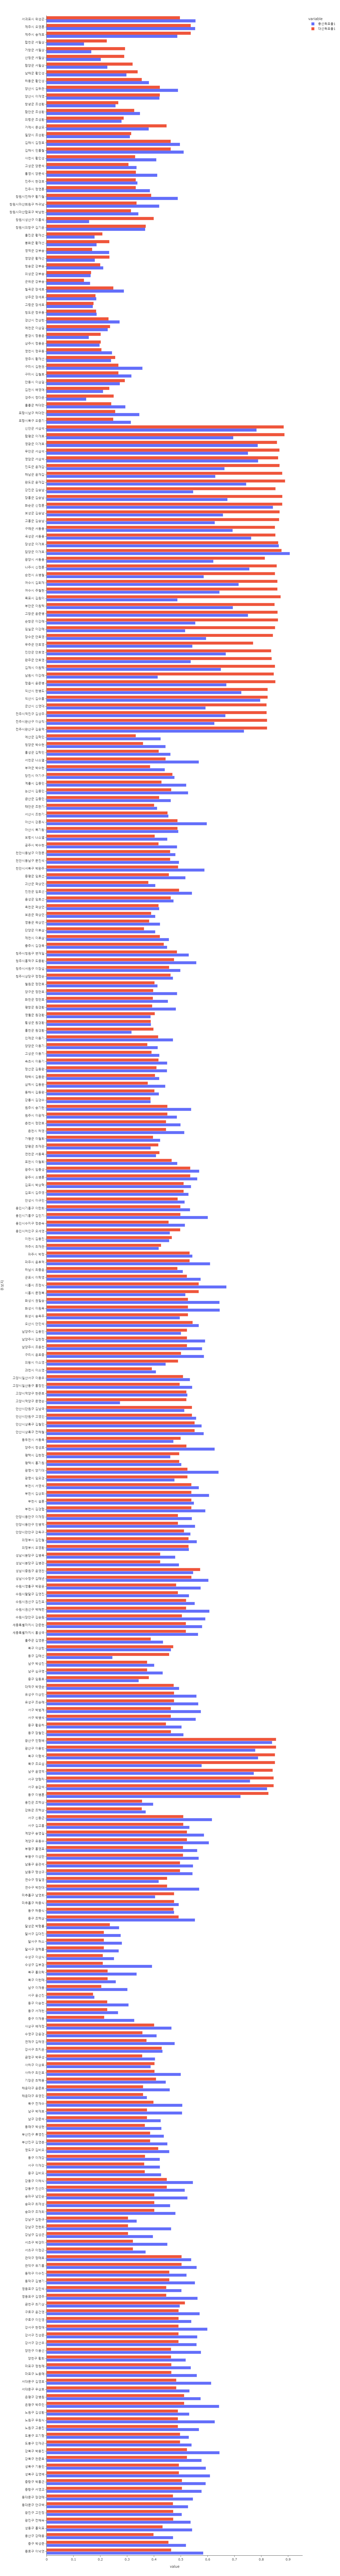

In [216]:
fig = px.bar(df_final, x=['총선득표율1', '대선득표율1'], y='후보자', orientation='h')
fig.update_layout(
    template="simple_white",
    # barmode="stack",
    barmode="group",
    height=10000,
    uniformtext_minsize=10,
    uniformtext_mode='hide',
)
fig.show()

In [43]:
# # XlsxWriter를 엔진으로 사용하여 Pandas Excel Writer를 작성
# writer = pd.ExcelWriter('20대대선vs_21대총선_지역구별_지지율차.xlsx', engine='xlsxwriter')

# # 데이터 프레임을 각각 워크시트에 작성
# df_21.to_excel(writer, sheet_name='21대_총선', index=False)

# df_21_candi.to_excel(writer, sheet_name='21대_총선_후보자', index=False)
# df_21_candi_big2.to_excel(writer, sheet_name='21대_총선_후보자_양당', index=False)

# df_21_vote.to_excel(writer, sheet_name='21대_총선_득표', index=False)
# df_21_vote_sum.to_excel(writer, sheet_name='21대_총선_득표_선거구명', index=False)

# df_21_total.to_excel(writer, sheet_name='21대_총선_후보자득표', index=False)

# df_20.to_excel(writer, sheet_name='20대_대선', index=False)
# df_20_sum.to_excel(writer, sheet_name='20대_대선_합계', index=False)

# # Pandas Excel Writer를 닫고 Excel 파일 저장
# writer.save()

In [44]:
# driver.quit()